In [1]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 59.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pymupdf  # PyMuPDF
import re
import json
from collections import Counter
import uuid
import os
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------
# Utility Functions
# ---------------------------------------------

def normalize(txt):
    """Normalizes text by stripping, lowercasing, and removing punctuation."""
    if not txt:
        return ""
    txt = txt.strip().lower()
    txt = re.sub(r'[-:;·•.,]+', ' ', txt)
    txt = re.sub(r'\s+', ' ', txt)
    return txt

# ---------------------------------------------
# Stage 1: Block-Level Feature Extraction
# ---------------------------------------------

def extract_blocks_with_features(pdf_path):
    """
    Extracts text blocks from a PDF and computes features for each block.
    This version aggregates features from lines into a single block representation.
    """
    try:
        doc = pymupdf.open(pdf_path)
    except Exception as e:
        print(f"Error opening PDF {pdf_path}: {e}")
        return []

    blocks_data = []

    all_font_sizes = []
    for page in doc:
        blocks = page.get_text("dict").get("blocks", [])
        for b in blocks:
            if b['type'] == 0 and "lines" in b:
                for l in b["lines"]:
                    for s in l["spans"]:
                        if s["text"].strip():
                            all_font_sizes.append(s["size"])
    avg_doc_font = sum(all_font_sizes) / len(all_font_sizes) if all_font_sizes else 12.0

    for page_num, page in enumerate(doc):
        page_width = page.rect.width
        blocks = page.get_text("dict").get("blocks", [])
        prev_block_bottom = 0

        for block in blocks:
            if "lines" not in block:
                continue

            all_spans = [s for l in block["lines"] for s in l["spans"] if s["text"].strip()]
            if not all_spans:
                continue

            block_text = " ".join(s["text"] for s in all_spans).strip()

            # Refined noise filter
            if not block_text or (len(block_text) < 3 and not block_text.isdigit()):
                 continue

            font_sizes = [s["size"] for s in all_spans]
            font_flags = [s["flags"] for s in all_spans]

            max_font_size = max(font_sizes)
            is_bold = any(f & 16 for f in font_flags)

            first_line_text = block["lines"][0]["spans"][0]["text"].strip()
            has_number_prefix = bool(re.match(r'^(\d+(\.\d+)*|[IVXLCDM]+)[\.\)]?\s+', first_line_text))

            x0, y0, x1, y1 = block["bbox"]

            # --- Assemble the feature dictionary ---
            block_features = {
                "id": str(uuid.uuid4()),
                "text": block_text,
                "page": page_num,
                "word_count": len(block_text.split()), # Important new feature
                "font_size_norm": round(min(max_font_size / avg_doc_font, 3.0) / 3.0, 3),
                "is_bold": int(is_bold),
                "is_all_caps": int(block_text.upper() == block_text and block_text.replace(" ", "").isalpha()),
                "block_width_ratio": round((x1 - x0) / page_width, 3),
                "block_ends" : (x1/page_width),
                "is_centered": int(abs(((x0 + x1) / 2) - (page_width / 2)) < page_width * 0.1),
                "has_number_prefix": int(has_number_prefix),
                "first_letter_capital": int(block_text[0].isupper() if block_text else 0),
            }
            blocks_data.append(block_features)
            prev_block_bottom = y1

    doc.close()
    return blocks_data

# ---------------------------------------------
# Stage 1: label with blocks by comparing to grong truth labels in JSON files
# ---------------------------------------------
def label_pdf_blocks(blocks, y_path):
    """
    Applies labels to extracted blocks based on a ground truth JSON file.
    The matching is done against the entire block's text.
    """
    with open(y_path, 'r', encoding='utf-8') as yf:
        y_data = json.load(yf)

    outlines = y_data.get("outline", [])
    title = y_data.get("title", "")

    # Create a lookup for faster matching
    outline_map = {normalize(o.get("text", "")): o for o in outlines if o.get("text")}
    normalized_title = normalize(title)

    for block in blocks:
        block['label'] = 0  # Default label is 0 (e.g., paragraph)
        normalized_block_text = normalize(block.get("text", ""))

        # Check for title match
        if normalized_title and (normalized_block_text in normalized_title or normalized_title in normalized_block_text):
            block['label'] = 1 # Label 1 for TITLE
            continue

        # Check for outline (heading) match
        for norm_outline_text, outline_data in outline_map.items():
            if norm_outline_text in normalized_block_text:
                level_str = outline_data.get("level", "H0")
                # Assuming level is like "H1", "H2", etc.
                level_num = int(re.search(r'\d+', level_str).group()) if re.search(r'\d+', level_str) else 0
                block['label'] = level_num + 1 # H1 -> 2, H2 -> 3, etc.
                break # Stop after first match

    return blocks




In [4]:
import os

directory = '/content/drive/MyDrive/Adobe_Hackathon/input'
output_path = '/content/real_output.json'
output = []

for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    # print(filepath)
    output_filepath = filepath.replace("input","output").replace(".pdf",".json")
    features = extract_blocks_with_features(filepath)
    labeled_features = label_pdf_blocks(features, output_filepath)
    output+=(labeled_features)



# DATA ANALYSIS

In [5]:
real_output = []
print(f"len of output is {len(output)}")
for item in output:
  # print(item.get("text","")+"\n\n-----")
  if len(item.get("text",""))>4:
    real_output.append(item)


with open(output_path, "w", encoding="utf-8") as f:
        json.dump(real_output, f, indent=2, ensure_ascii=False)

print(f"len of output is {len(real_output)}")

print(f"\n✅ Labeled features saved to {output_path}")
print("\n📋 Preview (first 10 lines):\n")
# real_output[:10]

len of output is 60471
len of output is 56988

✅ Labeled features saved to /content/real_output.json

📋 Preview (first 10 lines):



Pie chart saved as labels_pie_chart.png
0    45888
4     6350
3     2795
1     1030
2      925
Name: count, dtype: int64


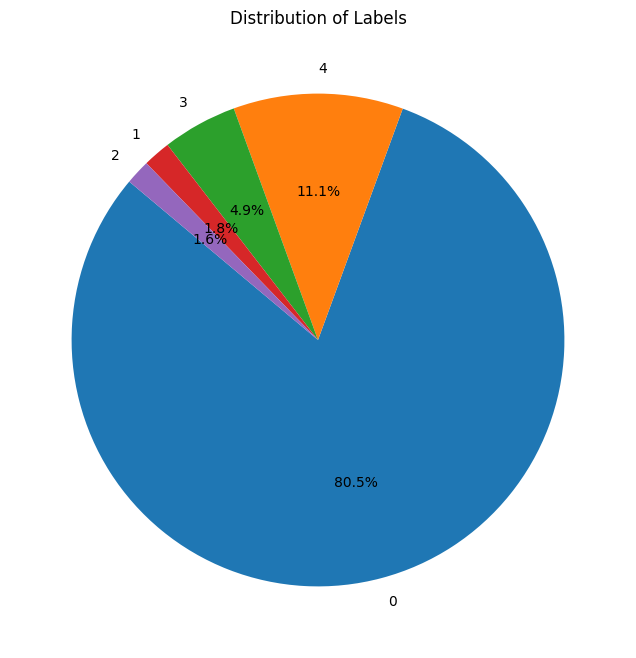

In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the JSON file
with open('/content/real_output.json', 'r') as f:
    data = json.load(f)

# Flatten the nested list and extract labels
labels = []
for item in data:
    labels.append(item['label'])

# Create a pandas Series for easy value counting
df = pd.Series(labels)

# Count the occurrences of each label
label_counts = df.value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels')
plt.ylabel('')  # Hide the y-label
plt.savefig('labels_pie_chart.png')

print("Pie chart saved as labels_pie_chart.png")
print(label_counts)

The above data is skewed

# BALANCING THE DATA

Dataset has been balanced.
Original size of label '0': 45888
Total size of other labels: 11100
New size of label '0' after downsampling: 11100

Balanced pie chart saved as labels_pie_chart_balanced.png

New Label Counts:
label
0    11100
4     6350
3     2795
1     1030
2      925
Name: count, dtype: int64


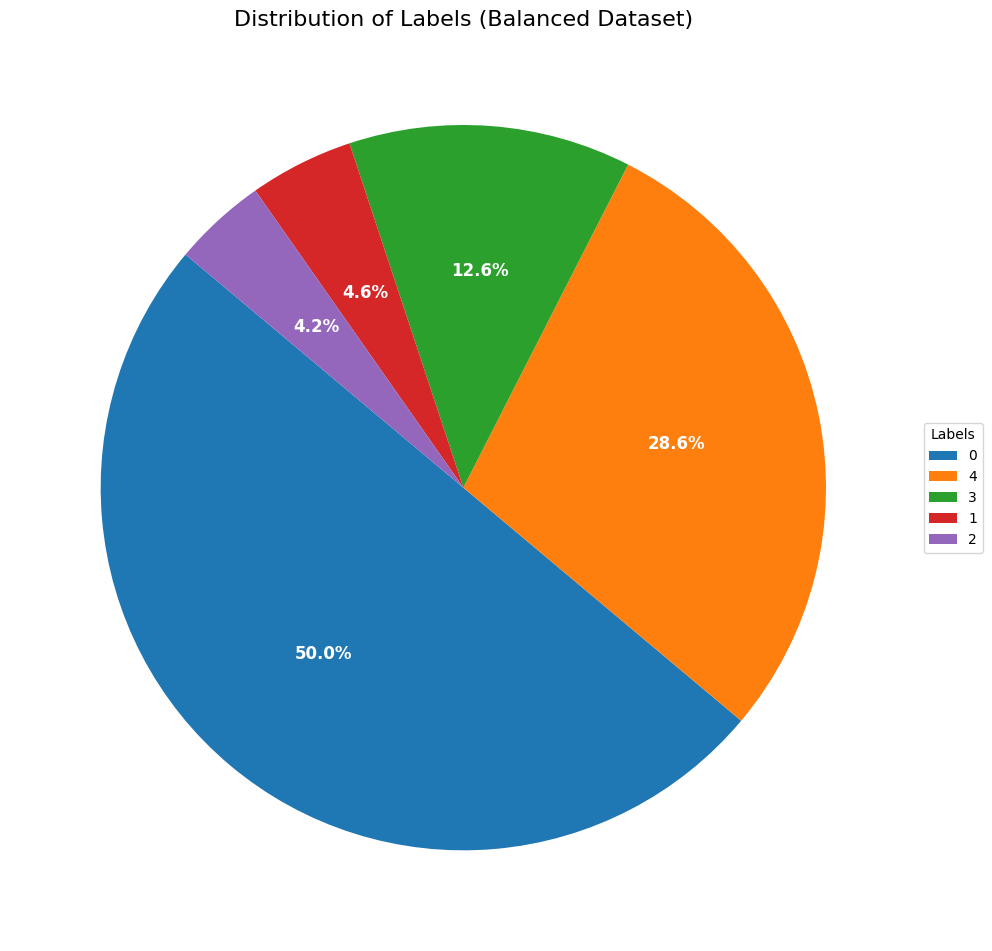

In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the JSON file
# Ensure 'real_output.json' is in the same directory as this script
try:
    with open('/content/real_output.json', 'r', encoding='utf-8') as f:
        data = json.load(f)
except FileNotFoundError:
    print("Error: 'real_output.json' not found. Please make sure the file is in the correct directory.")


# --- Data Balancing ---
# Convert the list of dictionaries to a pandas DataFrame for easier manipulation
df = pd.DataFrame(data)

# Separate the majority class (label 0) from the minority classes (all other labels)
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] != 0]

# Check if there are minority samples to balance against
if not df_minority.empty and not df_majority.empty:
    # Downsample the majority class.
    df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

    # Combine the downsampled majority class with the original minority classes
    # to create a new, balanced DataFrame.
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    print("Dataset has been balanced.")
    print(f"Original size of label '0': {len(df_majority)}")
    print(f"Total size of other labels: {len(df_minority)}")
    print(f"New size of label '0' after downsampling: {len(df_majority_downsampled)}")

else:
    # If there are no minority or majority samples, use the original dataframe
    df_balanced = df
    print("Dataset does not require balancing or is empty.")


# --- Visualization ---
label_counts = df_balanced['label'].value_counts()

# Create a pie chart from the balanced data
plt.figure(figsize=(10, 10))
pie_wedges, _, _ = plt.pie(
    label_counts,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 12, 'color': 'white', 'fontweight': 'bold'}
)
plt.title('Distribution of Labels (Balanced Dataset)', fontsize=16)
plt.legend(pie_wedges, label_counts.index, title="Labels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.ylabel('')
plt.tight_layout()

# Save the new pie chart to a different file to avoid overwriting the original
output_filename = 'labels_pie_chart_balanced.png'
plt.savefig(output_filename)

print(f"\nBalanced pie chart saved as {output_filename}")
print("\nNew Label Counts:")
print(label_counts)


The above balanced data has 50% body text blocks and another 50% of headings/subheadings

# TRAINING

In [8]:
import pandas as pd
import json
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb  # Changed from lightgbm to xgboost
from sklearn.metrics import classification_report

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Convert the 'text' column into numerical embeddings
text_embeddings = embedding_model.encode(df_balanced['text'].tolist(), show_progress_bar=True)

# Create a new DataFrame for the embeddings
embeddings_df = pd.DataFrame(text_embeddings, index=df_balanced.index)
embeddings_df = embeddings_df.add_prefix('embed_')

print(f"Embeddings generated with shape: {embeddings_df.shape}")

# Get the original tabular features (all columns except 'text' and 'label')
X_original = df_balanced.drop(columns=['text', 'label','id','word_count','page'])

# Combine original features with the new text embeddings
X_enriched = pd.concat([X_original, embeddings_df], axis=1)

print(f"Enriched feature set created with shape: {X_enriched.shape}")

# Define the target variable we want to predict
y = df_balanced['label']


# ---------------------------------------------
# 3. Split Data and Train Model
# ---------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X_enriched, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"\nData split into {len(X_train)} training samples and {len(X_test)} testing samples.")

# Train an XGBoost model on the new enriched data
print("\n🚀 Training XGBoost on data...")
# Using XGBClassifier for multi-class classification
xgb_enriched_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    random_state=42,
    use_label_encoder=False, # Suppress a potential future warning
    eval_metric='mlogloss'    # A common metric for multiclass classification
)
xgb_enriched_model.fit(X_train, y_train)


# ---------------------------------------------
# 4. Evaluate the New Model
# ---------------------------------------------
print("\n📊 Classification Report for XGBoost with Text Embeddings:\n")
y_pred_enriched = xgb_enriched_model.predict(X_test)
print(classification_report(y_test, y_pred_enriched, digits=3))



# ---------------------------------------------
# 5. Save the Model
# ---------------------------------------------
# Save the trained model to a file for later use
model_filename = 'xgb_enriched_model.json'
xgb_enriched_model.save_model(model_filename)
print(f"\n💾 Model saved successfully to '{model_filename}'")

# To load the model later, you can use:





modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/694 [00:00<?, ?it/s]

Embeddings generated with shape: (22200, 384)
Enriched feature set created with shape: (22200, 392)

Data split into 16650 training samples and 5550 testing samples.

🚀 Training XGBoost on data...

📊 Classification Report for XGBoost with Text Embeddings:

              precision    recall  f1-score   support

           0      0.823     0.892     0.856      2775
           1      1.000     0.942     0.970       258
           2      0.890     0.558     0.686       231
           3      0.805     0.597     0.685       699
           4      0.768     0.791     0.780      1587

    accuracy                          0.815      5550
   macro avg      0.857     0.756     0.795      5550
weighted avg      0.816     0.815     0.811      5550


💾 Model saved successfully to 'xgb_enriched_model.json'


In [9]:
model_filename = 'xgb_enriched_model.json'
loaded_model = xgb.XGBClassifier()
loaded_model.load_model(model_filename)
print("\n✅ Model loaded successfully.")


✅ Model loaded successfully.
